In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats

In [37]:
df = pd.read_csv('/content/drive/MyDrive/Quantium Analytics Project/TASK_2/QVI_data.csv')

In [38]:
df.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


Trial Stores (77, 86, 88):

These are stores selected by the client to test the new layout.
The trial period is Feb 2019 to April 2019.


Control Stores:

These are regular stores (not part of the trial).
They help us compare how sales, customer visits, and transactions change in trial stores.
They should have been operational throughout the entire pre-trial period.

How Do We Choose Control Stores?
<br>
We need to find stores that are similar to the trial stores before the trial period (before Feb 2019).

<br>
We will compare them using three key metrics:

Total monthly sales revenue
<br>Number of customers per month
<br>Number of transactions per customer per month


In [39]:
#First, we want to add a column with the year/month of the transaction.


# Change DATE column to store dates as datetimes
df['DATE'] = pd.to_datetime(df['DATE'])

# Then add a YEARMONTH column
df['YEARMONTH'] = df['DATE'].dt.strftime('%Y%m').astype('int64')
df

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,YEARMONTH
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium,201810
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream,201809
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget,201903
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget,201903
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream,201811
...,...,...,...,...,...,...,...,...,...,...,...,...,...
264829,2370701,2018-12-08,88,240378,24,Grain Waves Sweet Chilli 210g,2,7.2,210,GRNWVES,YOUNG FAMILIES,Mainstream,201812
264830,2370751,2018-10-01,88,240394,60,Kettle Tortilla ChpsFeta&Garlic 150g,2,9.2,150,KETTLE,YOUNG FAMILIES,Premium,201810
264831,2370961,2018-10-24,88,240480,70,Tyrrells Crisps Lightly Salted 165g,2,8.4,165,TYRRELLS,OLDER FAMILIES,Budget,201810
264832,2370961,2018-10-27,88,240481,65,Old El Paso Salsa Dip Chnky Tom Ht300g,2,10.2,300,OLD,OLDER FAMILIES,Budget,201810


The YEARMONTH column was added to aggregate the data at a monthly level. Here’s why it’s useful:

Grouping by Month: Since we need to compare trial and control stores before the trial period (before Feb 2019), we should analyze data at a monthly level rather than a daily level. The YEARMONTH column allows easy grouping of data by month.

Next, we should create a function that will be able to calculate the
<br>total sales,<br> number of customers, <br>transactions per customer, <br>chips per customer <br>average price per unit for each store and month.

In [40]:
grouped_df = df.groupby(["STORE_NBR","YEARMONTH"])

In [41]:
grouped_df.first()

LYLTY_CARD_NBR       DATE  TXN_ID  PROD_NBR  \
STORE_NBR YEARMONTH                                                
1         201807               1011 2018-07-29      12        84   
          201808               1020 2018-08-16      26        19   
          201809               1002 2018-09-16       2        58   
          201810               1000 2018-10-17       1         5   
          201811               1004 2018-11-02       5        96   
...                             ...        ...     ...       ...   
272       201902             272002 2019-02-04  269636        78   
          201903             272010 2019-03-08  269644        49   
          201904             272002 2019-04-28  269637        81   
          201905             272034 2019-05-06  269673       108   
          201906             272000 2019-06-09  269634         3   

                                                    PROD_NAME  PROD_QTY  \
STORE_NBR YEARMONTH                                                       
1         201807        GrnWves Plus Btroot & Chilli Jam 180g         2   
          201808          Smiths Crinkle Cut  Snag&Sauce 150g         1   
          201809        Red Rock Deli Chikn&Garlic Aioli 150g         1   
          201810       Natural Chip        Compny SeaSalt175g         2   
          201811               WW Original Stacked Chips 160g         1   
...                                                       ...       ...   
272       201902             Thins Chips Salt &  Vinegar 175g         2   
          201903     Infuzions SourCream&Herbs Veg Strws 110g         2   
          201904              Pringles Original   Crisps 134g         2   
          201905     Kettle Tortilla ChpsHny&Jlpno Chili 150g         2   
          201906     Kettle Sensations   Camembert & Fig 150g         2   

                     TOT_SALES  PACK_SIZE       BRAND              LIFESTAGE  \
STORE_NBR YEARMONTH                                                            
1         201807           6.2        180     GRNWVES  OLDER SINGLES/COUPLES   
          201808           2.6        150      SMITHS  YOUNG SINGLES/COUPLES   
          201809           2.7        150         RRD  YOUNG SINGLES/COUPLES   
          201810           6.0        175     NATURAL  YOUNG SINGLES/COUPLES   
          201811           1.9        160  WOOLWORTHS  OLDER SINGLES/COUPLES   
...                        ...        ...         ...                    ...   
272       201902           6.6        175       THINS         YOUNG FAMILIES   
          201903           7.6        110   INFUZIONS  YOUNG SINGLES/COUPLES   
          201904           7.4        134    PRINGLES         YOUNG FAMILIES   
          201905           9.2        150      KETTLE         YOUNG FAMILIES   
          201906           9.2        150      KETTLE         OLDER FAMILIES   

                    PREMIUM_CUSTOMER  
STORE_NBR YEARMONTH                   
1         201807          Mainstream  
          201808          Mainstream  
          201809          Mainstream  
          201810             Premium  
          201811          Mainstream  
...                              ...  
272       201902              Budget  
          201903             Premium  
          201904              Budget  
          201905          Mainstream  
          201906          Mainstream  

[3169 rows x 11 columns]

In [42]:
tot_sales = grouped_df['TOT_SALES'].sum()
n_cust = grouped_df['LYLTY_CARD_NBR'].nunique()
ntrans_percust = grouped_df['TXN_ID'].size() / n_cust
nchips_pertrans = grouped_df['PROD_QTY'].sum() / grouped_df['TXN_ID'].size()
avg_priceperunit = tot_sales / grouped_df['PROD_QTY'].sum()


metric_arrays =  [tot_sales, n_cust, ntrans_percust, nchips_pertrans, avg_priceperunit]

metrics_df = pd.concat(metric_arrays, axis=1)

metrics_df.columns = ['tot_sales', 'n_cust', 'ntrans_percust', 'nchips_pertrans', 'avg_priceperunit']
metrics_df.reset_index(inplace=True)

In [8]:
metrics_df.sample(10)

,STORE_NBR,YEARMONTH,tot_sales,n_cust,ntrans_percust,nchips_pertrans,avg_priceperunit
1601,139,201807,36.5,9,1.000000,1.333333,3.041667
1505,131,201807,267.4,56,1.071429,1.300000,3.428205
1881,162,201811,778.4,88,1.284091,2.000000,3.444248
659,57,201903,807.4,99,1.252525,2.000000,3.255645
420,37,201903,442.2,44,1.159091,2.000000,4.335294
2281,196,201812,1007.4,113,1.274336,2.000000,3.497917
1576,136,201906,229.3,50,1.040000,1.192308,3.698387
1590,138,201808,707.4,86,1.232558,1.962264,3.400962
640,56,201808,634.5,81,1.271605,1.902913,3.237245
292,26,201809,1262.8,123,1.121951,2.000000,4.575362


In [9]:
metrics_df.shape

(3169, 7)

In [43]:
month_counts = metrics_df.groupby('STORE_NBR').YEARMONTH.nunique().reset_index()

# Selecting Stores with Data for 12 Full Months
stores_fullobs = month_counts[month_counts.YEARMONTH ==12].STORE_NBR

# Keeping Only the Stores with Full 12-Month Observations
pretrial_metrics = metrics_df[metrics_df['STORE_NBR'].isin(stores_fullobs)]

# filtering the pretrial_metrics DataFrame to only include data before February 2019
pretrial_metrics = pretrial_metrics[pretrial_metrics.YEARMONTH < 201902]
print(pretrial_metrics.shape)
pretrial_metrics.head()

(1820, 7)


,STORE_NBR,YEARMONTH,tot_sales,n_cust,ntrans_percust,nchips_pertrans,avg_priceperunit
0,1,201807,206.9,49,1.061224,1.192308,3.337097
1,1,201808,176.1,42,1.023810,1.255814,3.261111
2,1,201809,278.8,59,1.050847,1.209677,3.717333
3,1,201810,188.1,44,1.022727,1.288889,3.243103
4,1,201811,192.6,46,1.021739,1.212766,3.378947



Now we need to work out a way of ranking how similar each potential control store is to the trial store. We can calculate how correlated the performance of each potential control store is to the trial store.

In [11]:
def calc_corr(trial, metric_col, input_table = pretrial_metrics):
    trial_stores = [77, 86, 88]
    control_stores = stores_fullobs[~stores_fullobs.isin(trial_stores)] # filtering out the trial stores and select only the control stores.

    # Keep the trial store values to perform correlation with
    trial_vals = input_table[input_table["STORE_NBR"] == trial][metric_col].reset_index()
    corr_table = pd.DataFrame(columns = ['YEARMONTH', 'trial_store', 'control_store', 'correlation'])

    # Find the correlation for each control store
    for control in control_stores:
        # Keep the control store values to perform correlation with
        control_vals = input_table[input_table["STORE_NBR"] == control][metric_col].reset_index()
        corr_row = pd.DataFrame(columns = ['YEARMONTH', 'trial_store', 'control_store', 'correlation'])
        corr_row.YEARMONTH = list(input_table[input_table.STORE_NBR == control]["YEARMONTH"])
        corr_row.trial_store = trial
        corr_row.control_store = control
        corr_row.correlation = control_vals.corrwith(trial_vals, axis=1)
        corr_table = pd.concat([corr_table, corr_row]) # add each store's block to the dataframe
    return (corr_table)

In [12]:
trial_stores = [77, 86, 88]
corr_table = pd.DataFrame(columns = ['YEARMONTH', 'trial_store', 'control_store', 'correlation'])
for store in trial_stores:
    corr_section = calc_corr(store, ['tot_sales', 'n_cust', 'ntrans_percust', 'nchips_pertrans', 'avg_priceperunit'] )
    corr_table = pd.concat([corr_table, corr_section])

<ipython-input-11-92d431e3545e>:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  corr_table = pd.concat([corr_table, corr_row]) # add each store's block to the dataframe
<ipython-input-12-e9cc65fab22d>:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  corr_table = pd.concat([corr_table, corr_section])
<ipython-input-11-92d431e3545e>:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-

In [13]:
corr_table

,YEARMONTH,trial_store,control_store,correlation
0,201807,77,1,0.070544
1,201808,77,1,0.027332
2,201809,77,1,0.002472
3,201810,77,1,-0.019991
4,201811,77,1,0.030094
...,...,...,...,...
2,201809,88,272,0.533160
3,201810,88,272,0.591056
4,201811,88,272,0.566378
5,201812,88,272,0.594442


Apart from correlation, we can also calculate a standardised metric based on the absolute difference between the trial store's performance and each control store's performance. Write a function to calculate the magnitude distance.

In [14]:
def calc_magdist(trial, metric_col, input_table= pretrial_metrics):
  trial_stores = [77, 86, 88]
  control_stores = stores_fullobs[~stores_fullobs.isin(trial_stores)]
  dist_table = pd.DataFrame()

  for control in control_stores:
    dist_row = pd.DataFrame()
    dist_row = abs(input_table[input_table["STORE_NBR"] == trial].reset_index()[metric_col]\
                  - input_table[input_table["STORE_NBR"] == control].reset_index()[metric_col])

    dist_row.insert(0, 'YEARMONTH', list(input_table[input_table.STORE_NBR == control]["YEARMONTH"]))
    dist_row.insert(1, 'trial_store', trial)
    dist_row.insert(2, 'control_store', control)
    dist_table = pd.concat([dist_table, dist_row])

  for col in metric_col:
    maxdist = dist_table[col].max()
    mindist = dist_table[col].min()
    dist_table[col] = 1 - (dist_table[col] - mindist) / (maxdist - mindist)

  dist_table['mag_measure'] = dist_table[metric_col].mean(axis= 1)
  return dist_table


Now we will use the functions to find the control stores! We'll select control stores based on how similar monthly total sales in dollar amounts and monthly number of customers are to the trial stores. So we will need to use our functions to get four scores, two for each of total sales and total customers.

In [15]:
def calc_corrdist_score(trial, metric_col, input_table= pretrial_metrics):
  corr_vals = calc_corr(trial, metric_col, input_table)
  mag_vals = calc_magdist(trial, metric_col, input_table)
  mag_vals = mag_vals.drop(columns = metric_col, axis= 1)

  combined_corr_dist = pd.merge(corr_vals, mag_vals, on= ['YEARMONTH', 'trial_store', 'control_store' ])

  avg_corrmag = combined_corr_dist.groupby(['trial_store', 'control_store']).mean().reset_index()

  corr_weight = 0.5
  avg_corrmag['combined_score'] = corr_weight * avg_corrmag['correlation'] + (1 - corr_weight) * avg_corrmag['mag_measure']

  return avg_corrmag


In [17]:
def find_highest_score(trial):
  scores_tot_sales = calc_corrdist_score(trial, ['tot_sales'])
  scores_n_cust = calc_corrdist_score(trial, ['n_cust'])

  scores_control = pd.DataFrame()
  scores_control['control_store'] = scores_tot_sales['control_store']

  scores_control['correlation'] = 0.5 * scores_tot_sales['correlation'] + 0.5 * scores_n_cust['correlation']
  scores_control['mag_measure'] = 0.5 * scores_tot_sales['mag_measure'] + 0.5 * scores_n_cust['mag_measure']
  scores_control['scores'] = 0.5 * scores_tot_sales['combined_score'] + 0.5 * scores_n_cust['combined_score']

  scores_control = scores_control.sort_values(by= 'scores', ascending= False).reset_index(drop= True).head(5)
  return scores_control


In [18]:
trial_stores = [77, 86, 88]
for trial in trial_stores:
  print('Trail Store: ', trial)
  print(find_highest_score(trial))
  print()

Trail Store:  77


<ipython-input-11-92d431e3545e>:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  corr_table = pd.concat([corr_table, corr_row]) # add each store's block to the dataframe
<ipython-input-11-92d431e3545e>:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  corr_table = pd.concat([corr_table, corr_row]) # add each store's block to the dataframe


   control_store  correlation  mag_measure    scores
0            233          1.0     0.989804  0.994902
1             41          1.0     0.972041  0.986020
2             46          1.0     0.969523  0.984762
3             53          1.0     0.968421  0.984211
4            111          1.0     0.967981  0.983991

Trail Store:  86


<ipython-input-11-92d431e3545e>:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  corr_table = pd.concat([corr_table, corr_row]) # add each store's block to the dataframe
<ipython-input-11-92d431e3545e>:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  corr_table = pd.concat([corr_table, corr_row]) # add each store's block to the dataframe


   control_store  correlation  mag_measure    scores
0            155          1.0     0.976324  0.988162
1            109          1.0     0.968180  0.984090
2            225          1.0     0.965044  0.982522
3            229          1.0     0.957995  0.978997
4            101          1.0     0.945394  0.972697

Trail Store:  88


<ipython-input-11-92d431e3545e>:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  corr_table = pd.concat([corr_table, corr_row]) # add each store's block to the dataframe
<ipython-input-11-92d431e3545e>:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  corr_table = pd.concat([corr_table, corr_row]) # add each store's block to the dataframe


   control_store  correlation  mag_measure    scores
0             40          1.0     0.941789  0.970895
1             26          1.0     0.917859  0.958929
2             72          1.0     0.908157  0.954079
3             58          1.0     0.900435  0.950217
4             81          1.0     0.887572  0.943786



From the above output, the stores with the highest scores are:

Store 233 for trial store 77 <br>
Store 155 for trial store 86 <br>
Store 40 for trial stre 88 <br>

Note that the combined store for the control cases of trial store 88 are lower than those of stores 77 and 86. This may suggest that the control stores may not match store 88 as well as for the other trial stores.

In [51]:
def make_plots(storepair, metric_col):
    trial = storepair[0]
    control = storepair[1]
    trial_plot = pretrial_metrics[pretrial_metrics.STORE_NBR == trial][['YEARMONTH', 'STORE_NBR', metric_col]]
    trial_plot = trial_plot.rename(columns = {metric_col: metric_col+'_trial'})
    control_plot = pretrial_metrics[pretrial_metrics.STORE_NBR == control][['YEARMONTH', 'STORE_NBR', metric_col]]
    control_plot = control_plot.rename(columns = {metric_col: metric_col+'_control'})

    other_stores = pretrial_metrics.loc[(pretrial_metrics.STORE_NBR != 77)][['YEARMONTH', 'STORE_NBR', metric_col]]
    other_stores = other_stores.loc[(pretrial_metrics.STORE_NBR != 233)]
    plot_other = other_stores.groupby('YEARMONTH')[metric_col].mean()

    ax = control_plot.plot.line(x = "YEARMONTH", y = metric_col+'_control', use_index=False, label = 'Control '+metric_col)
    ax_trial = trial_plot.plot.line(x = "YEARMONTH", y = metric_col+'_trial', use_index=False, ax=ax, label = 'Trial '+metric_col)
    ax_other = plot_other.plot.line(use_index = False, ax=ax, label = 'Other '+ metric_col)
    ax.set_ylabel(metric_col)
    plt.legend(title = 'STORE_NBR', loc = "upper left",bbox_to_anchor=(1.0, 1.0))
    positions = (0,1,2,3,4,5,6)
    labels = ("201807", '201808', '201809', '201810', '201811', '201812', '201901')
    plt.xticks (positions, labels)
    titlestr = 'The Trial Store ' + str(storepair[0]) + ' and Control Store ' + str(storepair[1]) + ' in the Pre-Trial Period'
    ax.set_title(titlestr)

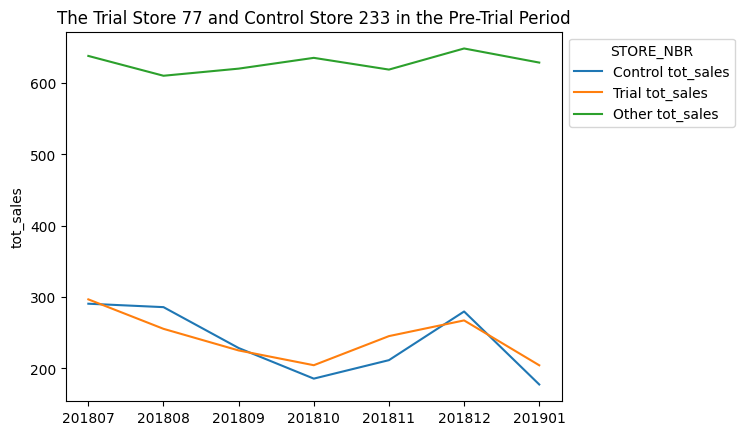

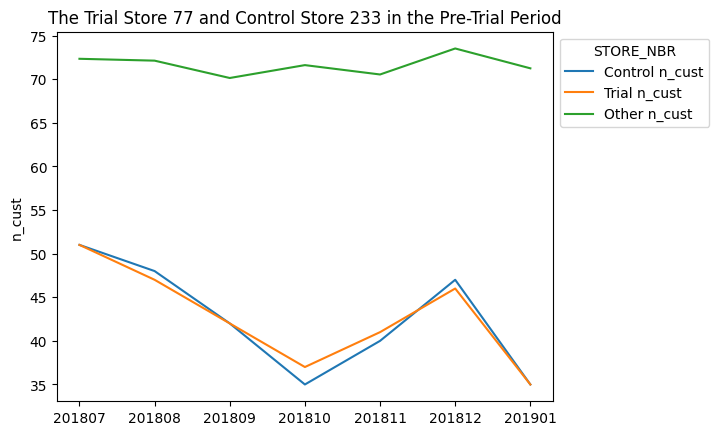

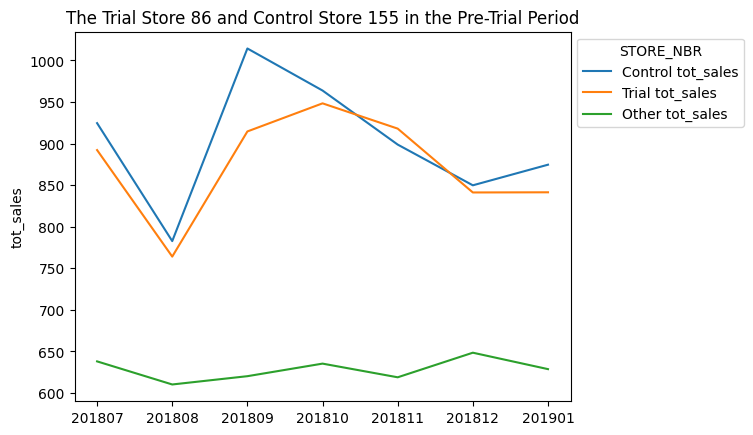

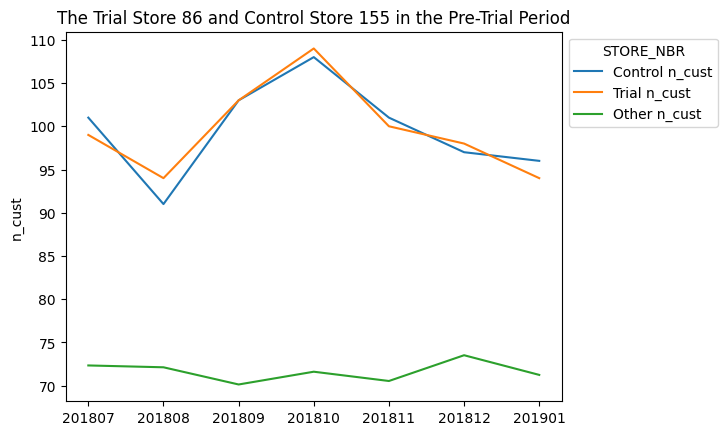

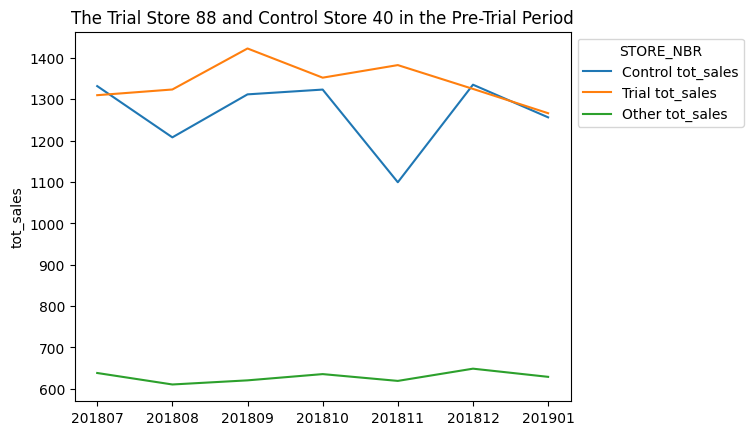

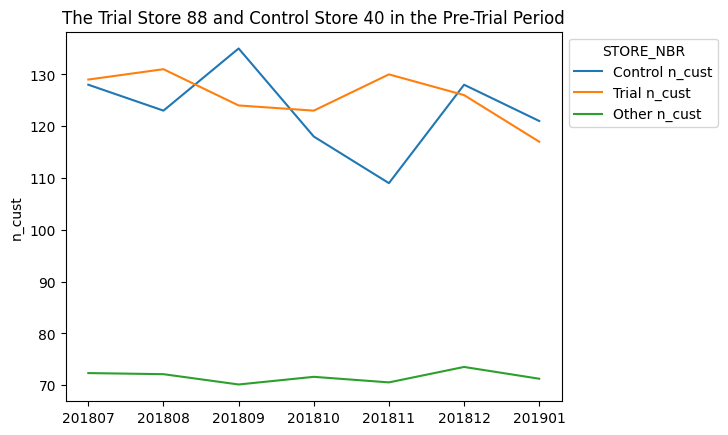

In [52]:

storepair = [[77, 233], [86, 155], [88, 40]]
metric_col = ['tot_sales', 'n_cust']
for pair in storepair:
    for metric in metric_col:
        make_plots(pair, metric)

In [47]:
# Calculate the scaling factor for the store pairs
scale_store77 = pretrial_metrics[pretrial_metrics.STORE_NBR == 77]['tot_sales'].sum()/pretrial_metrics[pretrial_metrics.STORE_NBR == 233]['tot_sales'].sum()
scale_store86 = pretrial_metrics[pretrial_metrics.STORE_NBR == 86]['tot_sales'].sum()/pretrial_metrics[pretrial_metrics.STORE_NBR == 155]['tot_sales'].sum()
scale_store88 = pretrial_metrics[pretrial_metrics.STORE_NBR == 88]['tot_sales'].sum()/pretrial_metrics[pretrial_metrics.STORE_NBR == 40]['tot_sales'].sum()

In [48]:
# Extract the control store data from the df and scale according to the store
scaled_control233 = metrics_df[metrics_df.STORE_NBR.isin([233])][['STORE_NBR', "YEARMONTH", 'tot_sales']]
scaled_control233.tot_sales *= scale_store77
scaled_control155 = metrics_df[metrics_df.STORE_NBR.isin([155])][['STORE_NBR', "YEARMONTH", 'tot_sales']]
scaled_control155.tot_sales *= scale_store86
scaled_control40 = metrics_df[metrics_df.STORE_NBR.isin([40])][['STORE_NBR', "YEARMONTH", 'tot_sales']]
scaled_control40.tot_sales *= scale_store88

# Combine the scaled control stores to a single df
scaledsales_control = pd.concat([scaled_control233, scaled_control155, scaled_control40]).reset_index(drop = True)
scaledsales_control = scaledsales_control.rename(columns = {'tot_sales':'scaled_tot_sales', 'STORE_NBR': 'CONTROL_NBR'})
# Get the trial period of scaled control stores
scaledsales_control_trial = scaledsales_control[(scaledsales_control.YEARMONTH>=201902) & (scaledsales_control.YEARMONTH<=201904)].reset_index(drop = True)

# Get the trial period of the trial stores
trialsales = metrics_df[metrics_df.STORE_NBR.isin([77,86,88])][['STORE_NBR', "YEARMONTH", 'tot_sales']].reset_index(drop = True)
trialsales = trialsales.rename(columns = {'STORE_NBR': 'TRIAL_NBR'})
trialsales_trial = trialsales[(trialsales.YEARMONTH >= 201902) & (trialsales.YEARMONTH <= 201904)].reset_index(drop = True)


Now that we have comparable sales figures for the control store, we can calculate the percentage difference between the scaled control sales and the trial store's sales during the trial period.

In [49]:
# Calculate the percentage difference between the control and trial store pairs for each month over the year
percentdiff = scaledsales_control.copy()
percentdiff[['TRIAL_NBR', 'tot_sales_t']] = trialsales[['TRIAL_NBR', 'tot_sales']]
percentdiff = percentdiff.rename(columns = {'scaled_tot_sales' : 'scaled_sales_c'})
percentdiff['sales_percent_diff'] = (percentdiff.tot_sales_t-percentdiff.scaled_sales_c)\
                                    /(0.5*((percentdiff.scaled_sales_c+percentdiff.tot_sales_t)))
percentdiff.head()

,CONTROL_NBR,YEARMONTH,scaled_sales_c,TRIAL_NBR,tot_sales_t,sales_percent_diff
0,233,201807,297.565550,77,296.8,-0.002576
1,233,201808,292.652187,77,255.5,-0.135554
2,233,201809,233.998916,77,225.2,-0.038323
3,233,201810,190.085733,77,204.5,0.073060
4,233,201811,216.597421,77,245.3,0.124281


Let's see if the difference is significant using a t-test. Our null hypothesis is that the trial period is the same as the pre-trial period; we will test with a null hypothesis that there is a 0-percent between the trial and control stores.



In [53]:
# As our null hypothesis is that the trial period is the same as the pre-trial period,
# let's take the standard deviation based on the scaled percentage difference in the pre-trial period.
pretrial_percentdiff = percentdiff[percentdiff.YEARMONTH < 201902]
pretrial_percentdiff_std = pretrial_percentdiff.groupby(['TRIAL_NBR'])['sales_percent_diff'].agg('std').reset_index()
dof = 6 # 7 months of data - 1

for stores in storepair: # stores numbers are stored as [trial, control] in storepair
    trialstore = stores[0]
    controlstore = stores[1]
    pretrial = percentdiff[(percentdiff.YEARMONTH < 201902) & (percentdiff.TRIAL_NBR == trialstore)]
    std = pretrial['sales_percent_diff'].agg('std')
    mean =  pretrial['sales_percent_diff'].agg('mean')
    trialperiod = percentdiff[(percentdiff.YEARMONTH >= 201902) & (percentdiff.YEARMONTH <= 201904) \
                              & (percentdiff.TRIAL_NBR == trialstore)]
    print("Trial store -", trialstore, "; control store -", controlstore)
    print("Month : t-statistic")
    for month in trialperiod.YEARMONTH.unique():
        xval = trialperiod[trialperiod.YEARMONTH == month]['sales_percent_diff'].item()
        tstat = ((xval - mean)/std)
        print(str(month), ' : ', tstat)
    print()

# Generate the t-statistic for the 95% percentile with 6 dof
print ('95th percentile value:', stats.t.ppf(1-0.05, 6))

Trial store - 77 ; control store - 233
Month : t-statistic
201902  :  -0.7171038288055838
201903  :  3.035317928855674
201904  :  4.708944418758219

Trial store - 86 ; control store - 155
Month : t-statistic
201902  :  1.4133618775921597
201903  :  7.123063846042147
201904  :  0.8863824572944234

Trial store - 88 ; control store - 40
Month : t-statistic
201902  :  -0.5481633746817577
201903  :  1.0089992743637823
201904  :  0.9710006270463672

95th percentile value: 1.9431802805153022


We can observe that the t-value for the trial store 77 is much larger than the 95th percentile value of the t-distribution for March and April - i.e. the increase in sales in the trial store 77 in March and April is statistically greater than in the control store. This can also be seen for March of trial store 86.

Let's create a more visual version of this by plotting the sales of the control store, the sales of the trial stores and the 95th percentile value of sales of the control store.



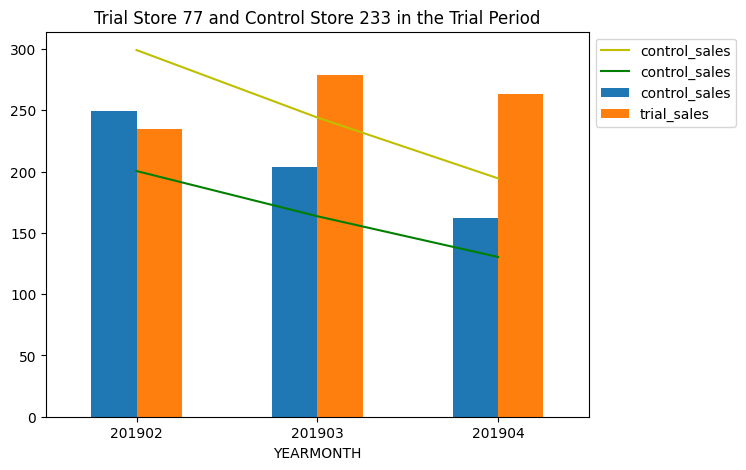

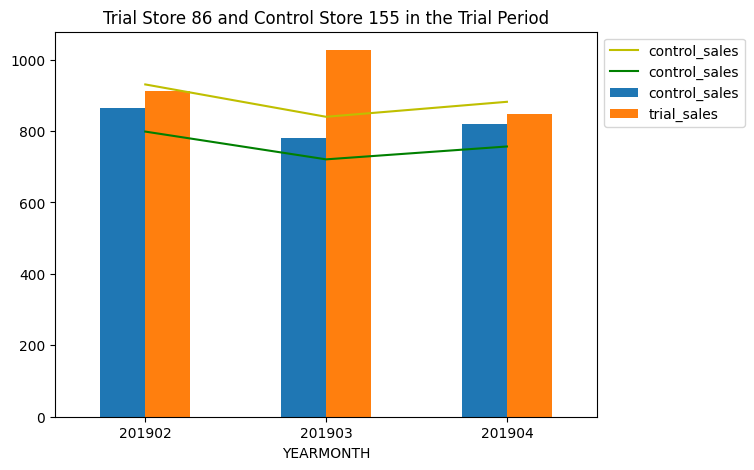

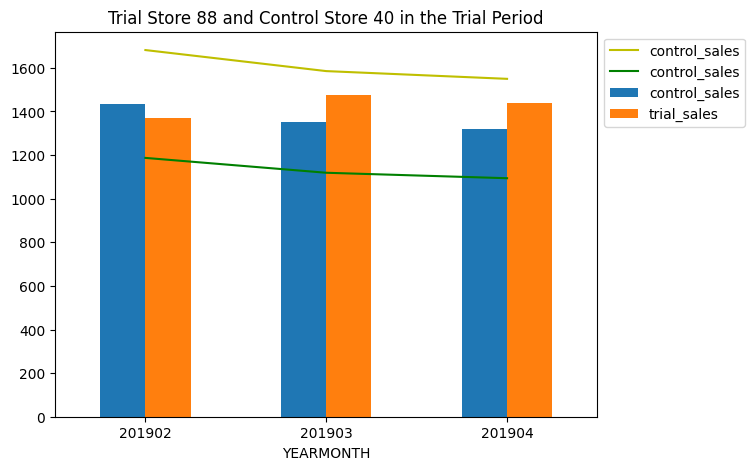

In [54]:

# First do bar graphs during the trial period
storepair = [[77, 233], [86, 155], [88, 40]]
for stores in storepair: # stores numbers are stored as [trial, control] in storepair
    trial = stores[0]
    control = stores[1]

    # Plot the bar chart of sales performance
    plot_control = percentdiff[(percentdiff['CONTROL_NBR'] == control) & (percentdiff.YEARMONTH >= 201902) & (percentdiff.YEARMONTH <= 201904)]\
                    [['YEARMONTH', 'CONTROL_NBR', 'scaled_sales_c']]
    plot_control = plot_control.rename(columns = {"CONTROL_NBR" : "STORE_NBR", "scaled_sales_c": "control_sales"})
    plot_trial = percentdiff[(percentdiff['TRIAL_NBR'] == trial) & (percentdiff.YEARMONTH >= 201902) & (percentdiff.YEARMONTH <= 201904)]\
                    [['YEARMONTH', 'TRIAL_NBR', 'tot_sales_t']]
    plot_trial = plot_trial.rename(columns = {"TRIAL_NBR" : "STORE_NBR", "tot_sales_t": "trial_sales"})
    toplot = plot_control[["YEARMONTH", "control_sales"]].merge(plot_trial[["YEARMONTH", "trial_sales"]],on="YEARMONTH").set_index("YEARMONTH")
    ax = toplot.plot(kind = 'bar',  figsize=(7, 5))


    # plot the thresholds as lines
    std = percentdiff[(percentdiff['CONTROL_NBR'] == control) & (percentdiff.YEARMONTH < 201902)]['sales_percent_diff'].std()
    threshold95 = plot_control.reset_index()[['YEARMONTH', 'control_sales']]
    threshold95.control_sales = threshold95.control_sales*(1+std*2)
    threshold5 = plot_control.reset_index()[['YEARMONTH', 'control_sales']]
    threshold5.control_sales = threshold5.control_sales*(1-std*2)
    ax95 = threshold95.plot.line(x = 'YEARMONTH', y = 'control_sales',color='y', figsize=(7, 5), use_index=False, ax = ax)
    ax5 = threshold5.plot.line(x = 'YEARMONTH', y = 'control_sales', color='g', figsize=(7, 5), use_index=False, ax = ax)

    # Other plot features
    plt.legend(loc = "upper left",bbox_to_anchor=(1.0, 1.0))
    titlestr = 'Trial Store ' + str(trial) + ' and Control Store ' + str(control) + ' in the Trial Period'
    ax.set_title(titlestr)
    plt.show()

In [55]:
scale_store77 = pretrial_metrics[pretrial_metrics.STORE_NBR == 77]['n_cust'].sum()/pretrial_metrics[pretrial_metrics.STORE_NBR == 233]['n_cust'].sum()
scale_store86 = pretrial_metrics[pretrial_metrics.STORE_NBR == 86]['n_cust'].sum()/pretrial_metrics[pretrial_metrics.STORE_NBR == 155]['n_cust'].sum()
scale_store88 = pretrial_metrics[pretrial_metrics.STORE_NBR == 88]['n_cust'].sum()/pretrial_metrics[pretrial_metrics.STORE_NBR == 40]['n_cust'].sum()

In [56]:
scaled_control233 = metrics_df[metrics_df.STORE_NBR.isin([233])][['STORE_NBR', "YEARMONTH", 'n_cust']]
scaled_control233.n_cust *= scale_store77
scaled_control155 = metrics_df[metrics_df.STORE_NBR.isin([155])][['STORE_NBR', "YEARMONTH", 'n_cust']]
scaled_control155.n_cust *= scale_store86
scaled_control40 = metrics_df[metrics_df.STORE_NBR.isin([40])][['STORE_NBR', "YEARMONTH", 'n_cust']]
scaled_control40.n_cust *= scale_store88

# Combine the scaled control stores to a single df
scaledncust_control = pd.concat([scaled_control233, scaled_control155, scaled_control40]).reset_index(drop = True)
scaledncust_control = scaledncust_control.rename(columns = {'n_cust':'scaled_n_cust', 'STORE_NBR': 'CONTROL_NBR'})
# Get the trial period of scaled control stores
scaledncust_control_trial = scaledncust_control[(scaledsales_control.YEARMONTH>=201902) & (scaledsales_control.YEARMONTH<=201904)].reset_index(drop = True)

# Get the trial period of the trial stores
trialncust = metrics_df[metrics_df.STORE_NBR.isin([77,86,88])][['STORE_NBR', "YEARMONTH", 'n_cust']].reset_index(drop = True)
trialncust = trialncust.rename(columns = {'STORE_NBR': 'TRIAL_NBR'})
trialncust_trial = trialncust[(trialncust.YEARMONTH >= 201902) & (trialsales.YEARMONTH <= 201904)].reset_index(drop = True)

In [57]:

# Calculate the percentage difference between the control and trial store pairs for each month over the year
percentdiff = scaledncust_control.copy()
percentdiff[['TRIAL_NBR', 'n_cust_t']] = trialncust[['TRIAL_NBR', 'n_cust']]
percentdiff = percentdiff.rename(columns = {'scaled_n_cust' : 'scaled_n_cust_c'})
percentdiff['cust_percent_diff'] = (percentdiff.n_cust_t-percentdiff.scaled_n_cust_c)\
                                    /(0.5*((percentdiff.scaled_n_cust_c+percentdiff.n_cust_t)))
percentdiff.head()

,CONTROL_NBR,YEARMONTH,scaled_n_cust_c,TRIAL_NBR,n_cust_t,cust_percent_diff
0,233,201807,51.171141,77,51,-0.003350
1,233,201808,48.161074,77,47,-0.024402
2,233,201809,42.140940,77,42,-0.003350
3,233,201810,35.117450,77,37,0.052208
4,233,201811,40.134228,77,41,0.021342


In [58]:

# As our null hypothesis is that the trial period is the same as the pre-trial period,
# let's take the standard deviation based on the scaled percentage difference in the pre-trial period.
pretrial_percentdiff = percentdiff[percentdiff.YEARMONTH < 201902]
pretrial_percentdiff_std = pretrial_percentdiff.groupby(['TRIAL_NBR'])['cust_percent_diff'].agg('std').reset_index()
dof = 6 # 7 months of data - 1

for stores in storepair: # stores numbers are stored as [trial, control] in storepair
    trialstore = stores[0]
    controlstore = stores[1]
    pretrial = percentdiff[(percentdiff.YEARMONTH < 201902) & (percentdiff.TRIAL_NBR == trialstore)]
    std = pretrial['cust_percent_diff'].agg('std')
    mean =  pretrial['cust_percent_diff'].agg('mean')
    trialperiod = percentdiff[(percentdiff.YEARMONTH >= 201902) & (percentdiff.YEARMONTH <= 201904) \
                              & (percentdiff.TRIAL_NBR == trialstore)]
    print("Trial store -", trialstore, "; control store -", controlstore)
    print("Month : t-statistic")
    for month in trialperiod.YEARMONTH.unique():
        xval = trialperiod[trialperiod.YEARMONTH == month]['cust_percent_diff'].item()
        tstat = ((xval - mean)/std)
        print(str(month), ' : ', tstat)
    print()

# Generate the t-statistic for the 95% percentile with 6 dof
print ('95th percentile value:', stats.t.ppf(1-0.05, 6))

Trial store - 77 ; control store - 233
Month : t-statistic
201902  :  -0.19886295797440687
201903  :  8.009609025380932
201904  :  16.114474772873923

Trial store - 86 ; control store - 155
Month : t-statistic
201902  :  6.220524882227514
201903  :  10.52599074274189
201904  :  3.0763575852842706

Trial store - 88 ; control store - 40
Month : t-statistic
201902  :  -0.3592881735131531
201903  :  1.2575196020616801
201904  :  0.6092905590514273

95th percentile value: 1.9431802805153022


We can see from the above results that similar to the total sales metric, there are statistically significant increases in the number of customers in stores 77 and 86 in at least 2 months during the trial period. However, there is no significant increase in store 88.

Let's create a more visual version of this by plotting the sales of the control store, the sales of the trial stores and the 95th percentile value of sales of the control store.

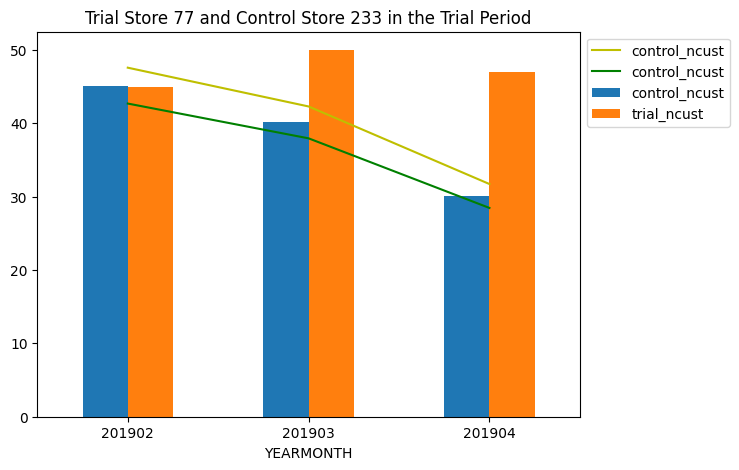

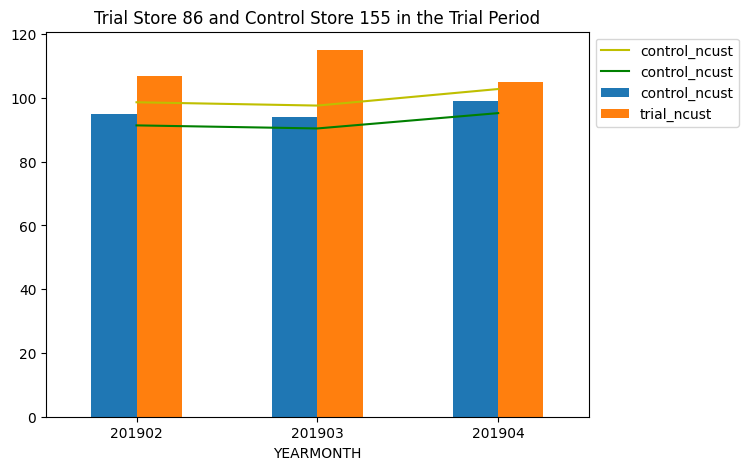

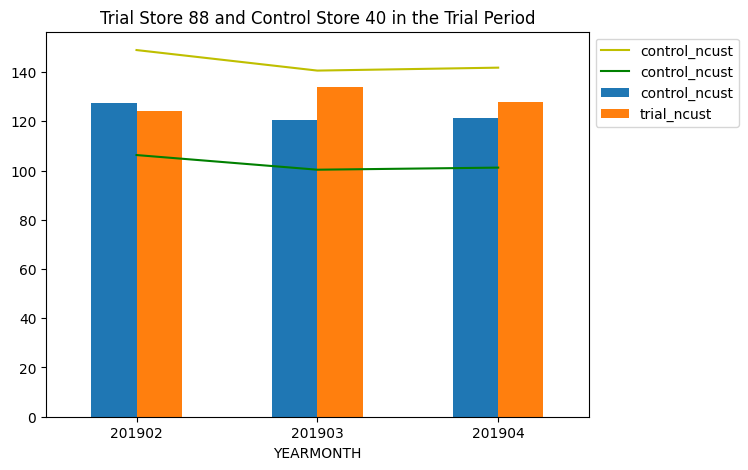

In [59]:
# First do bar charts to focus on the trial period
storepair = [[77, 233], [86, 155], [88, 40]]
for stores in storepair: # stores numbers are stored as [trial, control] in storepair
    trial = stores[0]
    control = stores[1]
    plot_control = percentdiff[(percentdiff['CONTROL_NBR'] == control) & (percentdiff.YEARMONTH >= 201902) & (percentdiff.YEARMONTH <= 201904)]\
                    [['YEARMONTH', 'CONTROL_NBR', 'scaled_n_cust_c']]
    plot_control = plot_control.rename(columns = {"CONTROL_NBR" : "STORE_NBR", "scaled_n_cust_c": "control_ncust"})
    plot_trial = percentdiff[(percentdiff['TRIAL_NBR'] == trial) & (percentdiff.YEARMONTH >= 201902) & (percentdiff.YEARMONTH <= 201904)]\
                    [['YEARMONTH', 'TRIAL_NBR', 'n_cust_t']]
    plot_trial = plot_trial.rename(columns = {"TRIAL_NBR" : "STORE_NBR", "n_cust_t": "trial_ncust"})
    toplot = plot_control[["YEARMONTH", "control_ncust"]].merge(plot_trial[["YEARMONTH", "trial_ncust"]],on="YEARMONTH").set_index("YEARMONTH")
    ax = toplot.plot(kind = 'bar',  figsize=(7, 5))


    # plot the thresholds as lines
    std = percentdiff[(percentdiff['CONTROL_NBR'] == control) & (percentdiff.YEARMONTH < 201902)]['cust_percent_diff'].std()
    threshold95 = plot_control.reset_index()[['YEARMONTH', 'control_ncust']]
    threshold95.control_ncust = threshold95.control_ncust*(1+std*2)
    threshold5 = plot_control.reset_index()[['YEARMONTH', 'control_ncust']]
    threshold5.control_ncust = threshold5.control_ncust*(1-std*2)
    ax95 = threshold95.plot.line(x = 'YEARMONTH', y = 'control_ncust',color='y', figsize=(7, 5), use_index=False, ax = ax)
    ax5 = threshold5.plot.line(x = 'YEARMONTH', y = 'control_ncust', color='g', figsize=(7, 5), use_index=False, ax = ax)

    # Other plot features
    plt.legend(loc = "upper left",bbox_to_anchor=(1.0, 1.0))
    titlestr = 'Trial Store ' + str(trial) + ' and Control Store ' + str(control) + ' in the Trial Period'
    ax.set_title(titlestr)
    plt.show()

In [1]:
storepair = [[77, 233], [86, 155], [88, 40]]
for stores in storepair: # stores numbers are stored as [trial, control] in storepair
    trial = stores[0]
    control = stores[1]
    plot_control = percentdiff[(percentdiff['CONTROL_NBR'] == control)]\
                    [['YEARMONTH', 'CONTROL_NBR', 'scaled_n_cust_c']]
    plot_control = plot_control.rename(columns = {"CONTROL_NBR" : "STORE_NBR", "scaled_n_cust_c": "control_ncust"})
    plot_trial = percentdiff[(percentdiff['TRIAL_NBR'] == trial)]\
                    [['YEARMONTH', 'TRIAL_NBR', 'n_cust_t']]
    plot_trial = plot_trial.rename(columns = {"TRIAL_NBR" : "STORE_NBR", "n_cust_t": "trial_ncust"})

    ax = plot_control.plot.line(x = "YEARMONTH", y = 'control_ncust', use_index=False, label = 'Control No. Cust')
    ax_trial = plot_trial.plot.line(x = "YEARMONTH", y = 'trial_ncust', use_index=False, ax=ax, label = 'Trial No. Cust')

    # plot the thresholds as lines
    std = percentdiff[(percentdiff['CONTROL_NBR'] == control) & (percentdiff.YEARMONTH < 201902)]['cust_percent_diff'].std()
    threshold95 = plot_control.reset_index()[['YEARMONTH', 'control_ncust']]
    threshold95.control_ncust = threshold95.control_ncust*(1+std*2)
    threshold5 = plot_control.reset_index()[['YEARMONTH', 'control_ncust']]
    threshold5.control_ncust = threshold5.control_ncust*(1-std*2)
    ax95 = threshold95.plot.line(x = 'YEARMONTH', y = 'control_ncust',color='y', linestyle = '--', figsize=(10, 5), use_index=False, ax = ax, label = '95th Percentile')
    ax5 = threshold5.plot.line(x = 'YEARMONTH', y = 'control_ncust', color='g',  linestyle = '--', figsize=(10, 5), use_index=False, ax = ax, label = '5th Percentile')
    ax.add_patch(Rectangle((6.5, 0), 3, 2000, alpha = 0.2, label = 'Trial period'))

    # Other plot features
    ax.set_ylabel('No. Customers')
    plt.legend(loc = "upper left",bbox_to_anchor=(1.0, 1.0))
    titlestr = 'Performance of Trial Store ' + str(trial) + ' and Control Store ' + str(control) + ' Over the 2018/19 Year'
    positions = (0,1,2,3,4,5,6,7,8,9, 10, 11)
    labels = ("201807", '201808', '201809', '201810', '201811', '201812', '201901', '201902', '201903', '201904', '201905', '201906')
    plt.xticks (positions, labels)
    ax.set_title(titlestr)
    plt.show()

NameError: name 'percentdiff' is not defined

It looks like the number of customers is significantly higher in all of the three months for store 77 and 86. This seems to suggest that the trial had a significant impact on increasing the number of customers in trial store 86 but as we saw, the statistical significance in the total sales were not as large, compared to store 77. We should check with the Category Manager if there were special deals in the trial store that were may have resulted in lower prices, impacting the results. Likewise to when considering the total sales, there appears to be no significant different in the number of customers between the control and trial stores for store 88 over the trial period.

##Conclusions

In this task, we found that the results for trial stores 77 and 86 showed a statistically significant difference in at least two stores of the three months of the trial period. However, this was not the case for store 88. We can check to see if the trial was implemented differently in store 88 but even so, we have been able to see that the trial has resulted in a significant increase in sales.